# UAS

In [1]:
pip install pymupdf4llm nltk networkx matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 37.5 MB/s eta 0:00:00


In [2]:
import fitz  # PyMuPDF
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pymupdf4llm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict

# --- Konfigurasi Awal ---
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
except:
    pass

def main(pdf_path):
    # ==========================================
    # TAHAP 1: Ekstrak Text
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 1: EKSTRAKSI TEKS")
    print(f"{'='*40}")

    text_content = extract_text_from_pdf(pdf_path)

    # Gunakan dummy text jika PDF tidak terbaca/kosong
    if len(text_content) < 50:
        text_content = """
       Sebagian besar ibu rumah tangga mendapatkan ide resep dari website resep. Resep dari website
tersebut memiliki kelebihan mudah untuk diakses dan memiliki resep yang cukup lengkap, namun
kelemahannya terkadang merepotkan pengguna karena harus memilih resep dari situs yang mana, dan
terdapat banyak sekali situs yang memuat resep yang sama, serta kebanyakan dari website resep di
internet tidak memiliki fitur untuk pencarian resep berdasarkan bahan-bahan yang dimiliki.
        Visit https://e-journal.upr.ac.id/index.php/JTI for recipes. DOIs: https://doi.org/10.47111/JTI
        """
        print("(Menggunakan teks dummy internal)")

    print(f"Jumlah Karakter: {len(text_content)}")

    # ==========================================
    # TAHAP 2: Preprocessing & Tokenisasi (Output Detail)
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 2: PREPROCESSING (CONTOH 3 TAHAP)")
    print(f"{'='*40}")

    sentences = sent_tokenize(text_content)
    print(f"Jumlah Kalimat Total: {len(sentences)}\n")

    # --- BAGIAN INI DIMODIFIKASI UNTUK MENAMPILKAN CONTOH ---

    # Kita panggil fungsi khusus yang mengembalikan contoh & data
    sequences, examples = preprocess_text_with_examples(sentences)

    # Tampilkan Contoh
    print("--- A. Contoh 3 Kalimat SEBELUM Preprocessing (Asli) ---")
    for i, s in enumerate(examples['raw']):
        print(f"{i+1}. {s}")

    print("\n--- B. Contoh 3 Kalimat SETELAH Preprocessing (Cleaning) ---")
    for i, s in enumerate(examples['cleaned']):
        print(f"{i+1}. {s}")

    print("\n--- C. Contoh 3 Kalimat SETELAH Tokenisasi (Unigram + Bigram) ---")
    for i, s in enumerate(examples['tokenized']):
        # Tampilkan sebagian jika terlalu panjang
        display_s = s[:10] + ['...'] if len(s) > 10 else s
        print(f"{i+1}. {display_s}")

    print(f"\nJumlah Sequence: {len(sequences)}")
    total_tokens = sum(len(s) for s in sequences)
    print(f"\nTotal Token Siap Proses: {total_tokens}")

    # ==========================================
    # TAHAP 3: Membangun Graph
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 3: MEMBANGUN GRAPH")
    print(f"{'='*40}")

    G = build_graph(sequences, window_size=3)
    print(f"Graph Terbentuk: {G.number_of_nodes()} Node, {G.number_of_edges()} Edge")

    # ==========================================
    # TAHAP 4: Perbandingan Score
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 4: PERBANDINGAN SCORE 4 METODE")
    print(f"{'='*40}")

    pagerank = nx.pagerank(G, weight='weight')
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)

    top_n = 20
    list_pr = get_top_list(pagerank, top_n)
    list_deg = get_top_list(degree, top_n)
    list_bet = get_top_list(betweenness, top_n)
    list_clo = get_top_list(closeness, top_n)

    def fmt_cell(item):
        return f"{item[0]} ({item[1]:.4f})"

    comparison_data = {
        'Rank': range(1, top_n + 1),
        'PageRank': [fmt_cell(x) for x in list_pr],
        'Degree': [fmt_cell(x) for x in list_deg],
        'Betweenness': [fmt_cell(x) for x in list_bet],
        'Closeness': [fmt_cell(x) for x in list_clo]
    }

    df_compare = pd.DataFrame(comparison_data)
    df_compare.set_index('Rank', inplace=True)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', 30)
    pd.set_option('display.width', 1000)

    print(df_compare)

    # ==========================================
    # TAHAP 5: Consensus Result
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 5: HASIL FINAL (CONSENSUS SCORE)")
    print(f"{'='*40}")

    final_ranking = calculate_consensus(
        [x[0] for x in list_pr],
        [x[0] for x in list_deg],
        [x[0] for x in list_bet],
        [x[0] for x in list_clo]
    )

    df_final = pd.DataFrame(final_ranking, columns=['Keyword', 'Total Score'])
    df_final.index += 1
    print(df_final)

    # ==========================================
    # TAHAP 6: Visualisasi
    # ==========================================
    top_20_words_list = [item[0] for item in final_ranking]
    # Memanggil visualisasi TANPA filter top_keywords (None) -> Akan memplot SEMUA
    visualize_graph(G, top_keywords=top_20_words_list)
    visualize_graph(G, top_keywords=None)

# --- FUNGSI PENDUKUNG ---

def extract_text_from_pdf(filepath):
    try:
        doc = fitz.open(filepath)
        text = pymupdf4llm.to_markdown(doc)
        doc.close()
        return text
    except:
        return ""

def preprocess_text_with_examples(sentences_list):
    """
    Fungsi ini dimodifikasi untuk mengembalikan sequences DAN contoh kalimat
    di setiap tahapannya.
    """
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))
    additional_junk = {'doi', 'http', 'https', 'www', 'com', 'org', 'journal', 'vol', 'issue', 'page'}
    stop_words.update(additional_junk)

    processed_sequences = []

    # Tempat menyimpan contoh (maksimal 3)
    examples = {
        'raw': [],
        'cleaned': [],
        'tokenized': []
    }

    example_count = 0

    for sentence in sentences_list:
        # 1. Simpan Contoh RAW (Asli)
        original_sentence = sentence.strip()
        if not original_sentence: continue

        # --- TAHAP PEMBERSIHAN (CLEANING) ---
        clean_sentence = re.sub(r'http\S+', '', sentence)
        clean_sentence = re.sub(r'www\S+', '', clean_sentence)
        clean_sentence = re.sub(r'\S*doi\S*', '', clean_sentence, flags=re.IGNORECASE)
        clean_sentence = re.sub(r'\d+', '', clean_sentence)
        clean_sentence = re.sub(r'[^a-zA-Z\s]', '', clean_sentence).lower()
        clean_sentence = clean_sentence.strip()

        # 2. Simpan Contoh CLEANED
        # (Hanya jika belum mencapai 3 contoh)

        # --- TAHAP TOKENISASI ---
        tokens = word_tokenize(clean_sentence)
        filtered = []
        for w in tokens:
            if w not in stop_words and len(w) > 2 and len(w) < 20:
                filtered.append(w)

        if not filtered: continue

        interleaved = []
        for i in range(len(filtered)):
            interleaved.append(filtered[i])
            if i < len(filtered) - 1:
                interleaved.append(f"{filtered[i]} {filtered[i+1]}")

        processed_sequences.append(interleaved)

        # 3. Simpan Contoh TOKENIZED & Update Counter
        if example_count < 3:
            examples['raw'].append(original_sentence)
            examples['cleaned'].append(clean_sentence)
            examples['tokenized'].append(interleaved)
            example_count += 1

    return processed_sequences, examples

def build_graph(sequences, window_size=3):
    d = defaultdict(int)
    for seq in sequences:
        for i in range(len(seq)):
            for j in range(1, window_size + 1):
                if i + j < len(seq):
                    u, v = seq[i], seq[i+j]
                    if u == v: continue
                    d[tuple(sorted((u, v)))] += 1
    G = nx.Graph()
    for (u, v), w in d.items():
        G.add_edge(u, v, weight=w)
    return G

def get_top_list(metric_dict, n):
    return sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:n]

def calculate_consensus(l1, l2, l3, l4):
    scores = defaultdict(int)
    lists = [l1, l2, l3, l4]
    for lst in lists:
        for rank, word in enumerate(lst):
            scores[word] += (20 - rank)
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:20]

def visualize_graph(G, top_keywords=None):
    # Setting Ukuran Canvas Besar untuk menampung seluruh kata
    plt.figure(figsize=(25, 25))

    if top_keywords:
        H = G.subgraph(top_keywords)
        title_text = "Top Keywords Graph"
        k_val = 1.0
        font_s = 10
        edge_alpha = 0.5
    else:
        # VISUALISASI SELURUH GRAPH
        H = G
        title_text = f"Full Word Graph ({G.number_of_nodes()} words)"
        # k lebih kecil agar node menyebar lebih luas, tapi tetap bergerombol
        k_val = 0.3
        font_s = 7 # Font kecil agar tidak saling menimpa parah
        edge_alpha = 0.2 # Garis tipis agar tidak ruwet

    if H.number_of_nodes() > 0:
        print(f"Sedang menggambar {H.number_of_nodes()} node... Mohon tunggu.")
        pos = nx.spring_layout(H, k=k_val, iterations=50, seed=42)

        d = dict(H.degree)
        # Ukuran node disesuaikan: yang penting besar, yang tidak penting kecil
        # Menggunakan log scale atau pembagian agar node raksasa tidak menutupi semua
        node_sizes = [v * 10 + 50 for v in d.values()]

        nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color='lightgreen', alpha=0.8)
        nx.draw_networkx_edges(H, pos, width=0.5, alpha=edge_alpha, edge_color='gray')
        nx.draw_networkx_labels(H, pos, font_size=font_s)

        plt.title(title_text, fontsize=20)
        plt.axis('off')
        plt.show()
    else:
        print("Graph kosong.")


Consider using the pymupdf_layout package for a greatly improved page layout analysis.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Saving 5.+JTI+Implementasi+Content-based+Filtering+Menggunakan+TF-IDF+dan+Cosine+Similarity+untuk++Sistem+Rekomendasi+Resep+Masakan+%28Rev%29.pdf to 5.+JTI+Implementasi+Content-based+Filtering+Menggunakan+TF-IDF+dan+Cosine+Similarity+untuk++Sistem+Rekomendasi+Resep+Masakan+%28Rev%29.pdf
Uploaded file: 5.+JTI+Implementasi+Content-based+Filtering+Menggunakan+TF-IDF+dan+Cosine+Similarity+untuk++Sistem+Rekomendasi+Resep+Masakan+%28Rev%29.pdf
Processing 5.+JTI+Implementasi+Content-based+Filtering+Menggunakan+TF-IDF+dan+Cosine+Similarity+untuk++Sistem+Rekomendasi+Resep+Masakan+%28Rev%29.pdf...

TAHAP 1: EKSTRAKSI TEKS
Jumlah Karakter: 22472

TAHAP 2: PREPROCESSING (CONTOH 3 TAHAP)
Jumlah Kalimat Total: 136

--- A. Contoh 3 Kalimat SEBELUM Preprocessing (Asli) ---
1. [E-ISSN 2656-0321]

[Vol 18 No 1]

[Januari 2024]

# IMPLEMENTASI CONTENT-BASED FILTERING MENGGUNAKAN TF-IDF AND COSINE SIMILARITY UNTUK SISTEM REKOMENDASI RESEP MASAKAN


Nova Noor Kamala Sari [a,1], Ressa Priskila [b,2.
2. *], 

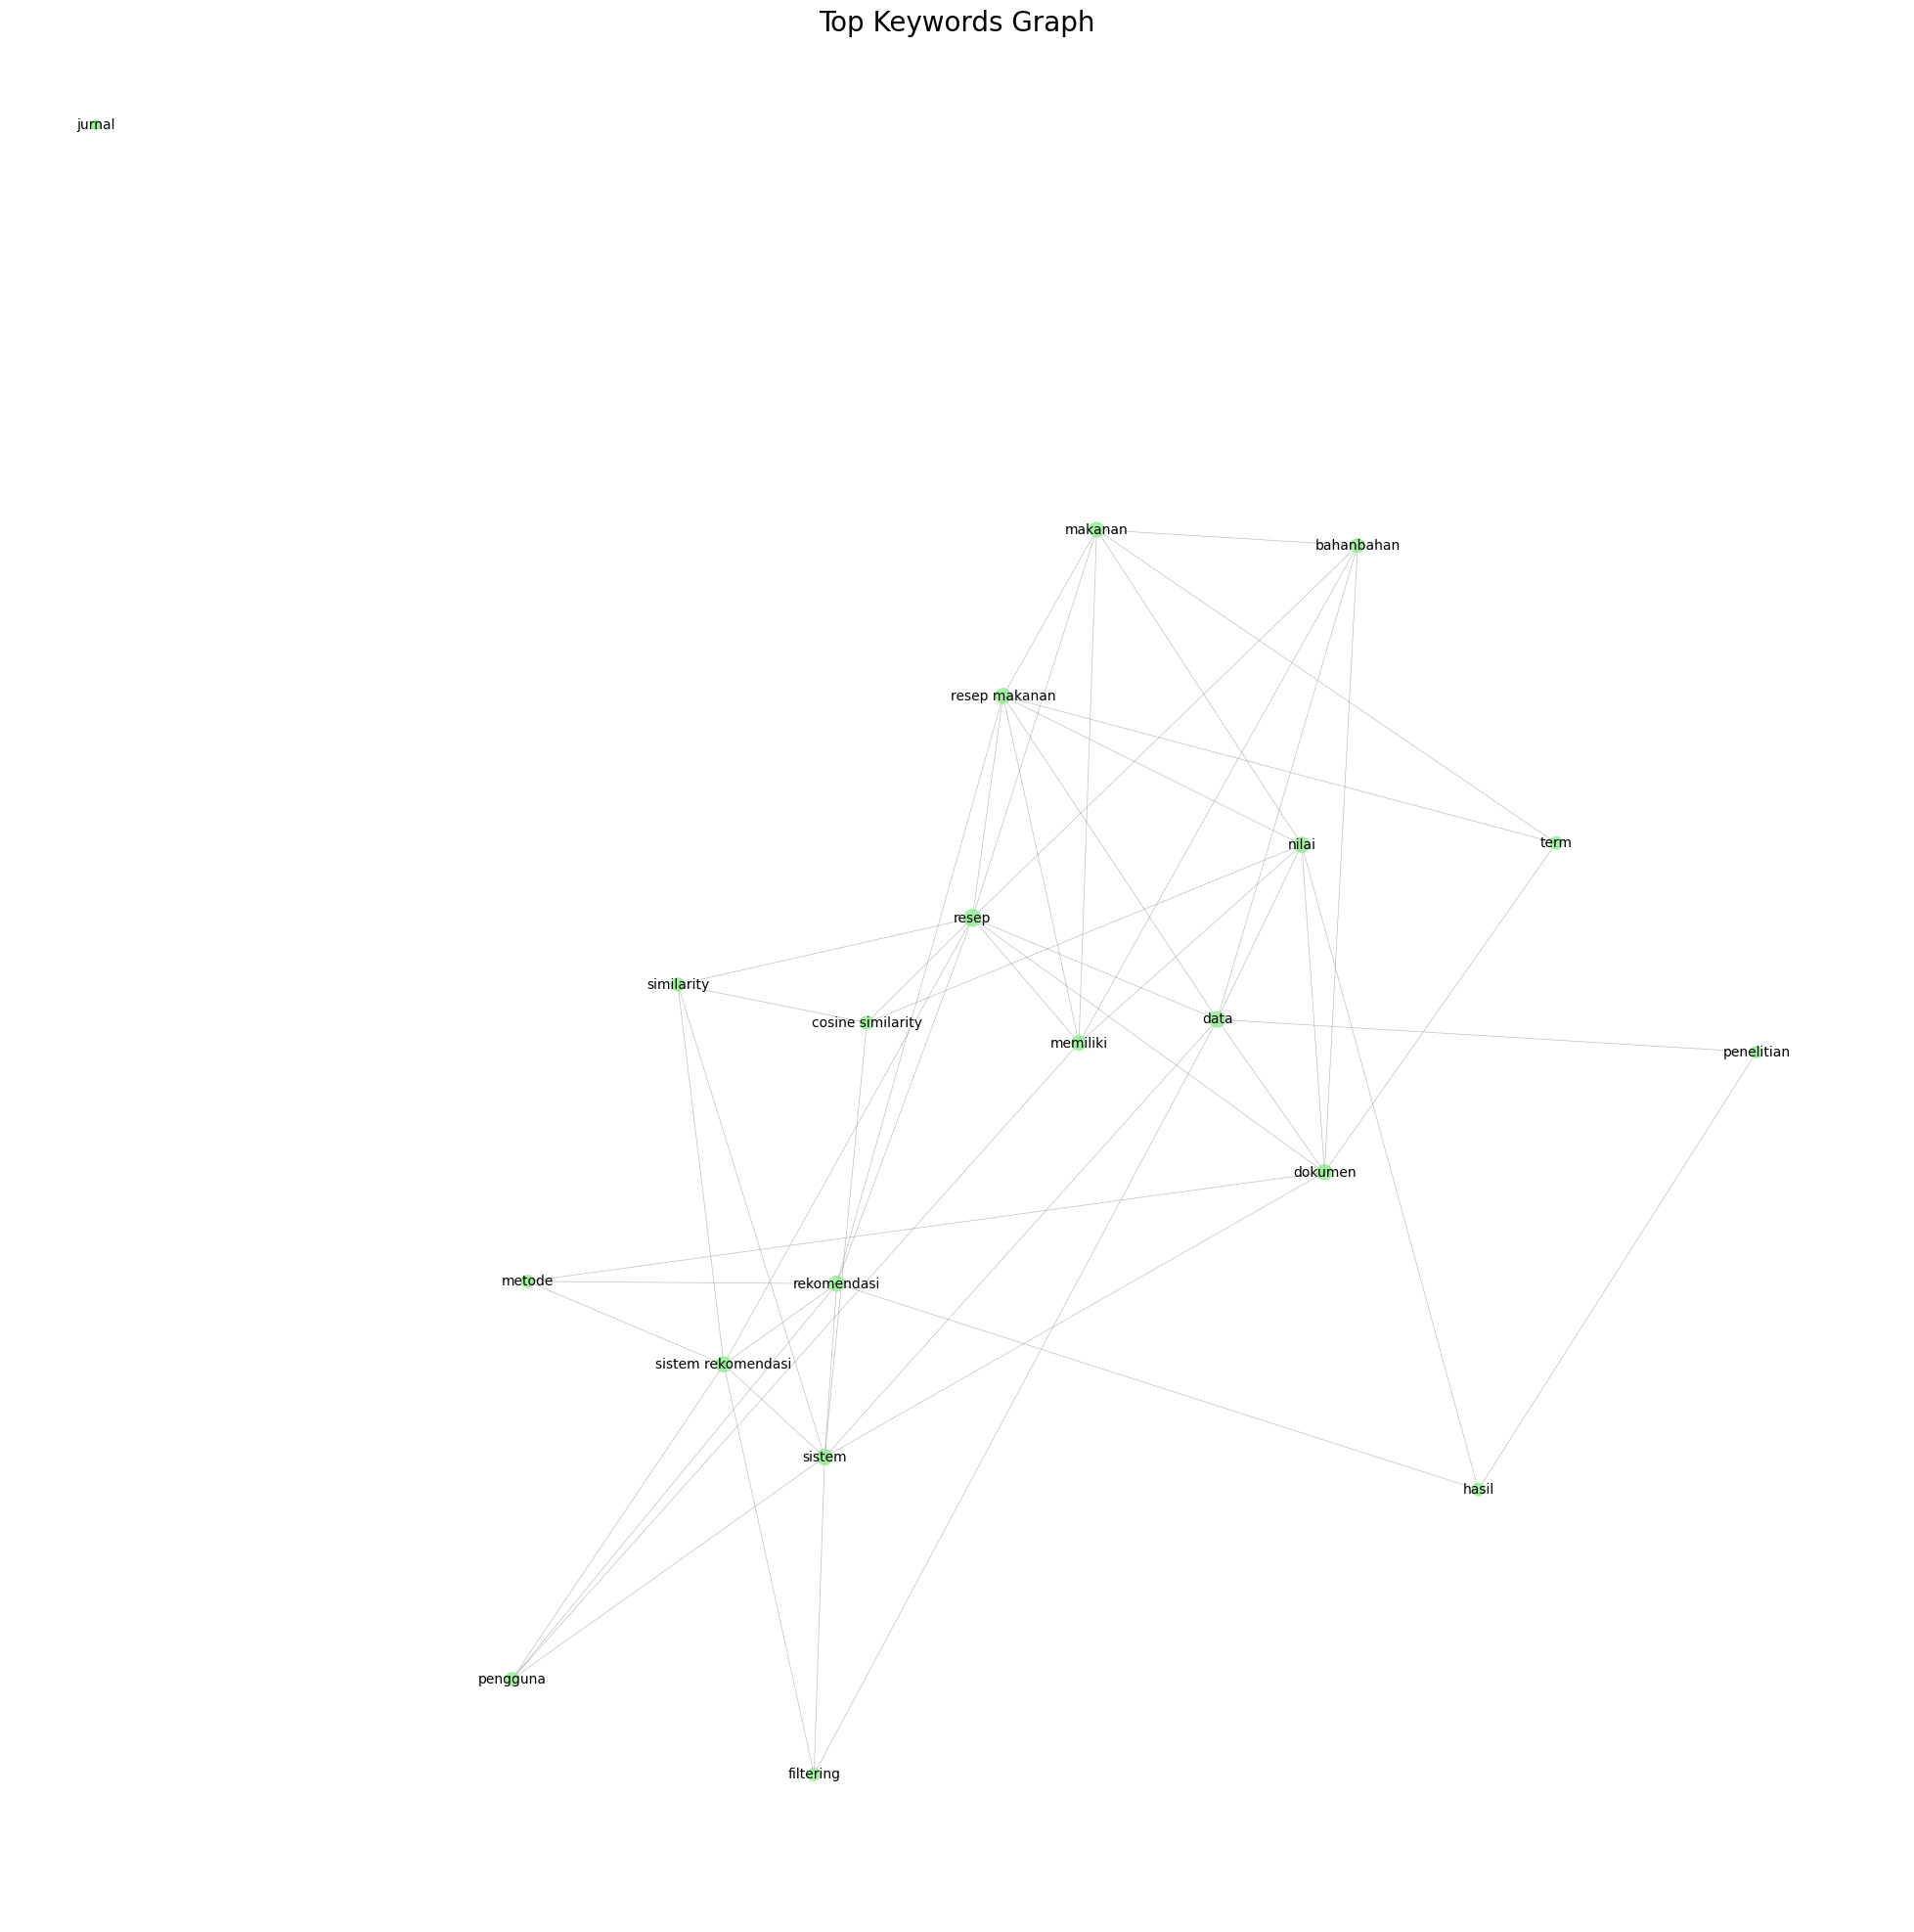

Sedang menggambar 1492 node... Mohon tunggu.


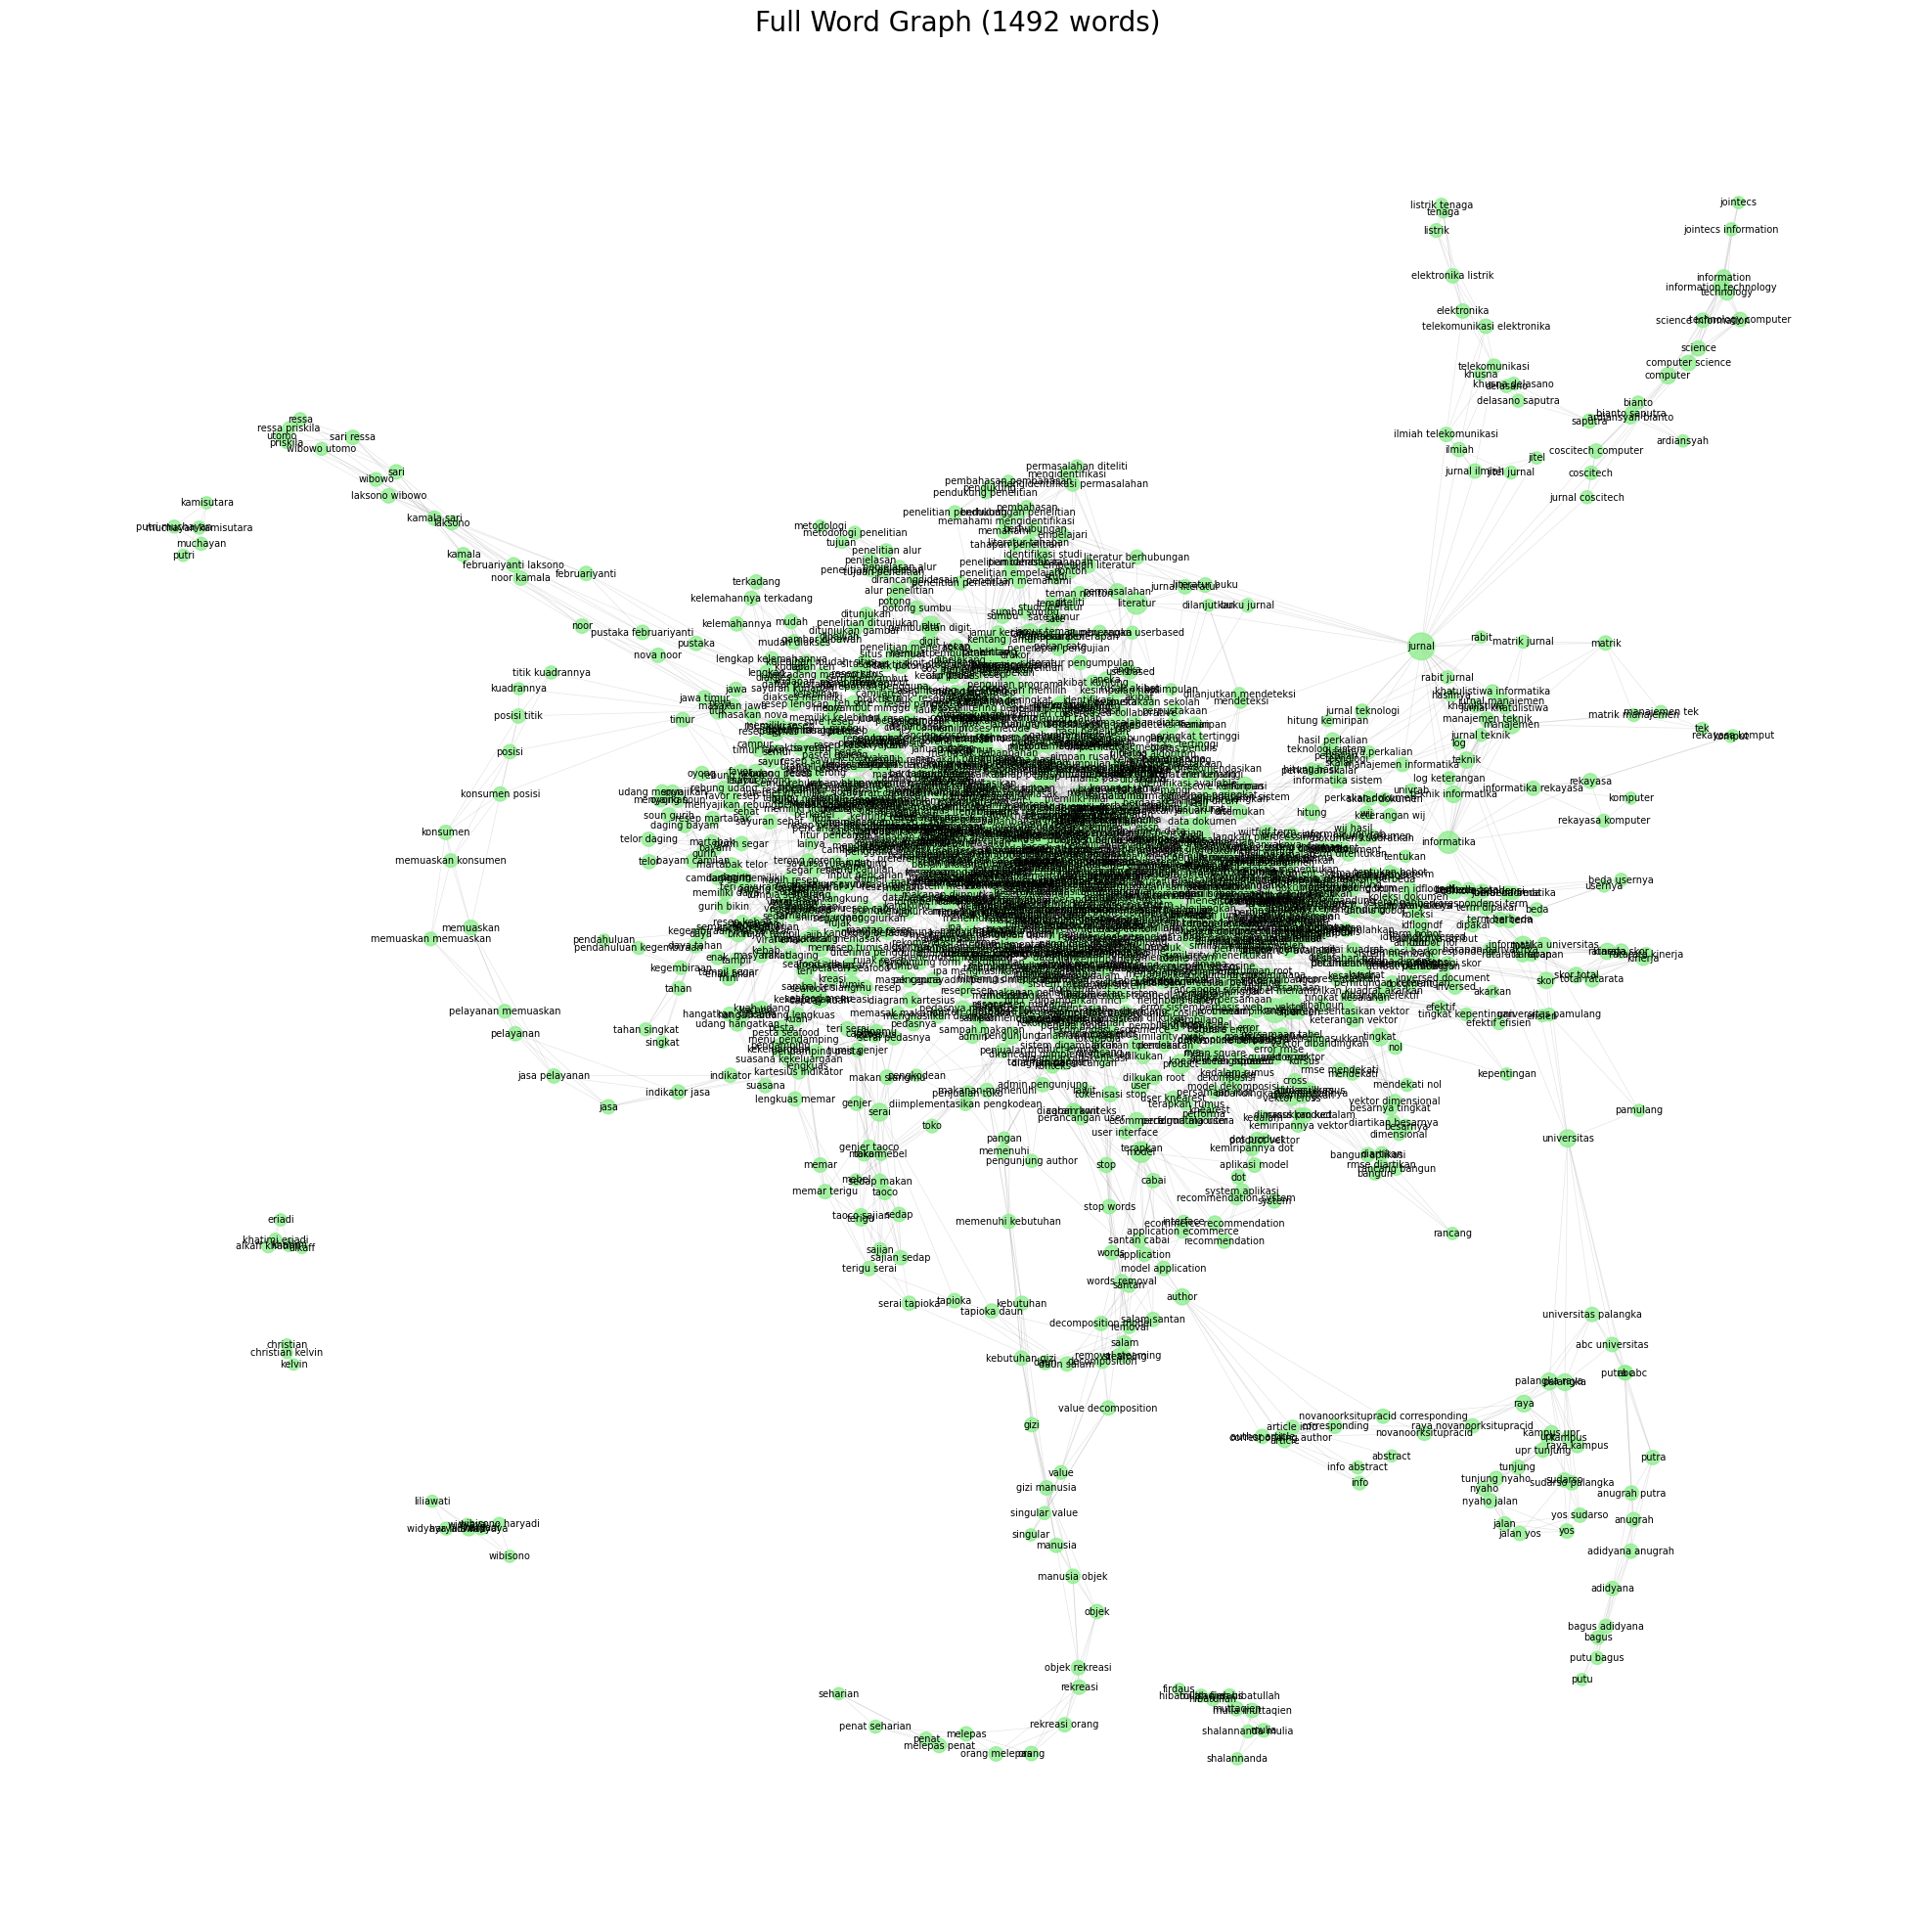

In [3]:
from google.colab import files
import os

# Hapus file PDF sebelumnya jika ada untuk menghindari konflik nama
!rm -f *.pdf

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    # Pastikan hanya satu file yang diproses untuk demonstrasi ini
    # Anda bisa memodifikasi ini jika ingin memproses beberapa file
    pdf_file_path = filename
    print(f'Processing {pdf_file_path}...')
    main(pdf_file_path)
    break # Hanya proses file pertama yang diupload

if not uploaded:
    print("No file uploaded. Please upload a PDF file to proceed.")